Generating libraries


In [17]:
import jax
import numpy as np
import jax.random as random
import jax.numpy as jnp
import jax.numpy.fft as jfft
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from numpy import sqrt
from numpy import round
from matplotlib import pyplot as plt
from matplotlib import contour
from jax.numpy.fft import fft2, ifft2
from jax.numpy.fft import fftn, ifftn
from numpy import real
from jax.example_libraries.stax import serial, Gelu
from jax.example_libraries.optimizers import optimizer, make_schedule
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter


In [18]:
# difinning the no of grid points in x, y and z
Nx = 128 # number of grid points in x be positive even integer number
Ny = 128 # number of grid points in y be positive even integer number
Nz = 128 # number of grid points in z be positive even integer number


2d allen cahn equations

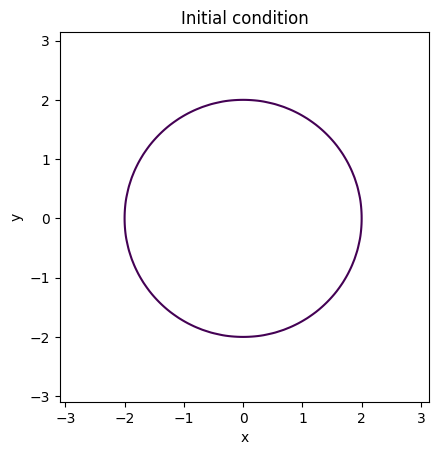

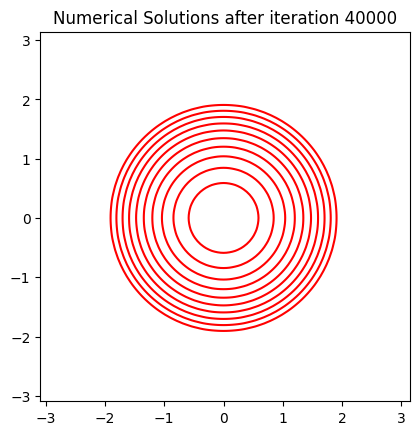

Initial and final conditions saved as:
- 'initial_condition.npy' and 'initial_condition.txt'
- 'final_output.npy' and 'final_output.txt'


In [19]:
# Define the parameters of the Allen-Cahn equation in 2d
Lx = 2.0 * jnp.pi #length of the domain in x
Ly = 2.0 * jnp.pi #length of the domain in y
hx = Lx / Nx #spatial step size in coordinate x
hy = Ly / Ny #spatial step size in coordinate y
dt = 0.0001 #time step size
T = 4 #final time
Nt = int(jnp.round(T/dt)) #number of time steps
ns = Nt / 20 #number of snapshots

# Define the grid points in x and y direction
def x_gridpoint(Nx, Lx, hx):
    x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
    return x
x = x_gridpoint(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
def y_gridpoint(Ny, Ly, hy):
    y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
    return y
y = y_gridpoint(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis 

# creating meshgrid in x and y direction
xx,yy = jnp.meshgrid(x,y) #creating meshgrid in x and y direction 

# defining parameters for the Allen-Cahn equation
epsillon = 0.05 #small parameter
cahn = epsillon**2 #cahn number  

# initial condition of allen cahn equation
u =jnp.tanh((2 -sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon)) #initial condition of allen cahn equation
# theta = jnp.arctan(y/x)
# u =jnp.tanh((1.7 - 1.2 * jnp.cos(6*theta) - sqrt(xx**2 + yy**2)) / (sqrt(2) *epsillon))


# defining the wavenumber in x and y direction , which is in fourier space
p = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2  , 0)]) # wavenumber in x direction
q = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)])


# square of wavenumber in x and y direction
p2 = p**2 # square of wavenumber in x direction
q2 = q**2 # square of wavenumber in y direction

# creating meshgrid in x and y direction for square of wavenumber
pp2, qq2 = jnp.meshgrid(p2, q2)
#print(pp2.shape) # creating meshgrid in x and y direction for square of wavenumber


# # plotting the initial condition of the Allen-Cahn equation


#this figure code is pervious code 
figure1 = plt.figure()
plt.contour(x, y, jnp.real(u.T), [0])
plt.gca().set_aspect('equal', adjustable='box') 
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# Save the initial condition
initial_u = np.array(u)  # Convert from JAX array to NumPy array
np.save("initial_condition.npy", initial_u)
np.savetxt("initial_condition.txt", initial_u)  # Save in .txt format (readable)




# # providing the range of iteration

for iter in range(1, Nt):
    u = jnp.real(u)
    # print(f'real space u ko size ={u.shape}')
    # Transforming the solution to the discrete Fourier space
    s_hat = jfft.fft2(cahn * u - dt * (u**3 - 3 * u)) # us is the real space
    # print(f's_hat ko size = {s_hat.shape}')
    v_hat = s_hat / (cahn + dt * (2 + cahn * (pp2 + qq2)))  # Allen-Cahn equation
    u = jfft.ifft2(v_hat)  # u_k+1 result
    # print(f'inverse u ko size = {u.shape}')
    

    if iter % ns == 0:
        plt.contour(x, y, jnp.real(u.T), [0], colors='red')
        plt.gca().set_aspect('equal', adjustable='box') 

# from this line to the print initial and final condition saved as for data saved purpose
# Save the final output
final_u = np.array(jnp.real(u))  # Convert from JAX array to NumPy array
np.save("final_output.npy", final_u)
np.savetxt("final_output.txt", final_u)  # Save in .txt format (readable)

plt.title('Numerical Solutions after iteration ' + str(Nt))
plt.show()


# # this is previous code   
# plt.title('Numerical Solutions after iteration ' + str(Nt))
# plt.show()

# Notify user of saved files
print("Initial and final conditions saved as:")
print("- 'initial_condition.npy' and 'initial_condition.txt'")
print("- 'final_output.npy' and 'final_output.txt'")



In [4]:
import jax
import jax.numpy as jnp
from jax import grad
from jax.random import PRNGKey, uniform
import jax.numpy.fft as jfft
import matplotlib.pyplot as plt
from jax import grad, jit, random

## Design the simple neural netweork

In [5]:
class SimpleNN:
    
    # define the initilization of the class
    
    def __init__(self, layers, key):
        self.layers = layers
        self.params = self.initialize_params(layers, key)


    

    def initialize_params(self, layers, key):
        keys = random.split(key, len(layers) - 1)
        params = []
        for i, k in enumerate(keys):
            w = random.normal(k, (layers[i], layers[i + 1])) * jnp.sqrt(2.0 / layers[i]) # javiar initilization
            b = jnp.zeros(layers[i + 1])
            params.append((w, b))
        return params


    

    def forward(self, params, x):
        for i, (w, b) in enumerate(params[:-1]):
            x = jnp.tanh(jnp.dot(x, w) + b)
        w, b = params[-1]
        out = jnp.dot(x, w) + b
        return out

##  Defining the physical loss function

In [6]:
def physical_loss(params, model, input_condition, L, N, dt, epsillon):

    u= model.forward(params, input_condition) # initial input data(real space input data)# perdict the data of the next u_k+1
     

    # k = jnp.fft.fftfreq(N, d=dt) * 2 * jnp.pi # creating the wave number 
    k = jnp.concatenate([2 * jnp.pi / L * jnp.arange(0, N//2), 2 * jnp.pi / L * jnp.arange(-N//2  , 0)])
    

    cahn = epsillon**2
    s_hat = (cahn * u - dt*(u**3 - 3* u)) # u is in Fourier space
    v_hat = s_hat / (cahn + dt * (2 + cahn * (k**2 + k**2)))

    # u_k = jnp.real(jnp.fft.ifft2(v_hat)) # v_hat gives the u_(k+1)_hat (on the fourier space) and this inverse to the real space and we get u_k+1

    return jnp.mean(jnp.real((u - v_hat)**2)) # return the mean square error of the u_k+1



## Defining the training data 

In [7]:
def train_fourier(model, input_condition, params, key, L=2*jnp.pi, N=128, epochs=10000, lr=1e-3):
    opt_state = params
    losses = []

    input_fft = jfft.fft2(input_condition)

    for epoch in range(epochs):
        loss = physical_loss(opt_state, model, input_fft, L, N, dt=0.0001, epsillon=0.05)
        losses.append(loss) 

        grads = grad(lambda params: physical_loss(params, model, input_fft, L, N, dt=0.0001, epsillon=0.05))(opt_state)

        opt_state = [(w - lr * gw, b - lr * gb) for (w, b), (gw, gb) in zip(opt_state, grads)]

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")
    
    return opt_state, losses

## Initilize the models, parameter and training setup

In [8]:
def init_model(key, layers, L=2*jnp.pi, N=128):
    params = []
    for i in range(len(layers) - 1):
        w_key, b_key = jax.random.split(key)
        weight = jax.random.normal(w_key, (layers[i], layers[i + 1])) * jnp.sqrt(2. / layers[i])
        bias = jnp.zeros(layers[i + 1])
        params.append((weight, bias))
    return params


## Trianing the data 

c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\jax\_src\lax\lax.py:2785: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Epoch 0, Loss: 0.0018217607866972685
Epoch 50, Loss: 0.001742171123623848
Epoch 100, Loss: 0.0016669505275785923
Epoch 150, Loss: 0.0015957121504470706
Epoch 200, Loss: 0.0015280707739293575
Epoch 250, Loss: 0.001463628257624805
Epoch 300, Loss: 0.0014019436202943325
Epoch 350, Loss: 0.0013424227945506573
Epoch 400, Loss: 0.0012840003473684192
Epoch 450, Loss: 0.001223828410729766
Epoch 500, Loss: 0.0011473371414467692
Epoch 550, Loss: 0.001094078179448843
Epoch 600, Loss: 0.0010479956399649382
Epoch 650, Loss: 0.0010060553904622793
Epoch 700, Loss: 0.0009670968283899128
Epoch 750, Loss: 0.0009305333951488137
Epoch 800, Loss: 0.0008960141567513347
Epoch 850, Loss: 0.0008632929529994726
Epoch 900, Loss: 0.0008321916102431715
Epoch 950, Loss: 0.0008025727001950145
Epoch 1000, Loss: 0.0007743134046904743
Epoch 1050, Loss: 0.0007473193109035492
Epoch 1100, Loss: 0.0007215028745122254
Epoch 1150, Loss: 0.0006967961089685559
Epoch 1200, Loss: 0.000673126894980669
Epoch 1250, Loss: 0.00065042

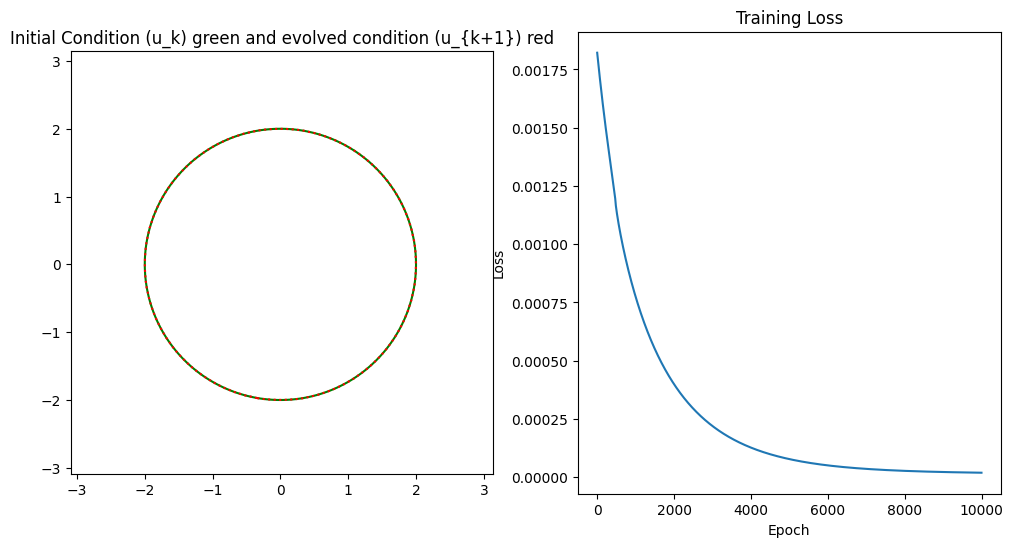

In [9]:
if __name__ == "__main__":

    key = PRNGKey(42)

    layers = [1, 64, 64, 1]  # 2 inputs data  (x, y), 2 hidden layers of size 64, 1 output
    model = SimpleNN(layers,key)

    N = 128
    Lx = 2.0 * jnp.pi
    Ly = 2.0 * jnp.pi
    L = 2.0 * jnp.pi
    
    hx = Lx / N
    hy = Ly / N

    x = jnp.linspace(-0.5*Lx +hx, 0.5*Lx, N)
    y = jnp.linspace(-0.5*Ly +hy, 0.5*Ly, N)

    xx, yy = jnp.meshgrid(x, y)

    epsillon = 0.05
    input_condition = jnp.tanh(( 2- jnp.sqrt(xx**2 + yy**2)) / jnp.sqrt(2 * epsillon)) #inital condition size is (128,128)
    input_condition_reshaped = input_condition.ravel() # merg two d array on the single aray with the help of ravel(bcoz network is fully connected layer which is expected 1d array)


    input_condition_reshaped = jnp.stack([input_condition_reshaped], axis=-1) # reshape the input condition 

    params = model.params # initalize the parameters

    trained_params, losses = train_fourier(model, input_condition_reshaped, params, key)


    

    

    # model outpou in real space
    model_output = model.forward(trained_params, input_condition_reshaped)  # Pass the trained parameters
    model_output_real = model_output.reshape(N,N) # Transform Fourier output back to real space

    # # plotting figures 
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Initial Condition (u_k) green and evolved condition (u_{k+1}) red")
    plt.contour(x, y, jnp.real(input_condition.T),levels=[0], colors="green")
    plt.contour(x, y, model_output_real.T, levels=[0], colors="red", linestyles = "dotted")
    plt.gca().set_aspect('equal', adjustable='box') 
    #plt.legend(loc="upper right")



    # Training loss
    plt.subplot(1, 2, 2)
    plt.title("Training Loss")
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()





3d of AC equation

In [10]:

# # defining parameter for 3d allen cahn

# Lx = 1.2  #length of the domain in x
# Ly = 1.2  #length of the domain in y
# Lz = 1.2  
# hx = Lx / Nx #spatial step size in coordinate x
# hy = Ly / Ny #spatial step size in coordinate y
# hz = Lz / Nz
# dt = 0.001 #time step size
# T = 0.5 #final time
# Nt = int(jnp.round(T/dt)) #number of time steps
# ns = Nt / 10 #number of snapshots


# # defining the function of (x,y,z) direction
# def x_gridpoint_3d(Nx, Lx, hx):
#     x = jnp.linspace(-0.5*Lx+hx,0.5*Lx,Nx)
#     return x
# x = x_gridpoint_3d(Nx, Lx, hx) #number of grid points in x direction and step size and limitation on x  axis
# # print(x.shape)

# def y_gridpoint_3d(Ny, Ly, hy):
#     y = jnp.linspace(-0.5*Ly+hy,0.5*Ly,Ny)
#     return y
# y = y_gridpoint_3d(Ny, Ly, hy) #number of grid points in y direction and step size and limitation on y  axis
# # print(y.shape) 

# def z_gridpoint_3d(Nz, Lz, hz):
#     z = jnp.linspace(-0.5*Lz+hz,0.5*Lz,Nz)
#     return z

# z = z_gridpoint_3d(Nz, Lz, hz) #number of grid points in z direction and step size and limitation on z  axis
# # print(z.shape)

# # creating the meshgrid in x, y, and z direction

# xx, yy, zz = jnp.meshgrid(x, y, z) #creating meshgrid in x, y, and z direction 
# # print(xx.shape , yy.shape, zz.shape)

# # defining the small parameter and cahn number

# epsillon = hx #small parameter
# cahn = epsillon**2 #cahn number 


# # initial condition of allen cahn equation in 3D
# u = np.random.rand(Nx, Ny, Nz)- 0.5 #initial condition of allen cahn equation

# # defining the wavenumber in x, y, and z direction
# kx = jnp.concatenate([2 * jnp.pi / Lx * jnp.arange(0, Nx//2), 2 * jnp.pi / Lx * jnp.arange(-Nx//2 , 0)]) # wavenumber in x direction
# ky = jnp.concatenate([2 * jnp.pi / Ly * jnp.arange(0, Ny//2), 2 * jnp.pi / Ly * jnp.arange(-Ny//2 , 0)]) # wavenumber in y direction
# kz = jnp.concatenate([2 * jnp.pi / Lz * jnp.arange(0, Nz//2), 2 * jnp.pi / Lz * jnp.arange(-Nz//2 , 0)]) # wavenumber in z direction

# # square of wavenumber in x, y, and z direction
# k2x = kx**2 # square of wavenumber in x direction
# k2y = ky**2 # square of wavenumber in y direction
# k2z = kz**2 # square of wavenumber in z direction
# print(k2x.shape)
# print(k2y.shape)
# print(k2z.shape)
# # creating meshgrid in x, y, and z direction for square of wavenumber
# kxx, kyy, kzz = jnp.meshgrid(k2x, k2y, k2z, indexing= 'ij')
# print(kxx.shape,kyy.shape,kzz.shape) # creating meshgrid in x, y, and z direction for square of wavenumber


# # Visualize the initial condition
# u_numpy = np.array(u)  # Convert JAX array to NumPy array


# #simulation loop for 3D Allen-Cahn equation
# for iter in range(1, Nt):
#     # Real part of the solution
#     u = jnp.real(u)
#     print(u)
   
    
#     # Fourier transform of the solution
#     s_hat = jfft.fftn(cahn * u - dt * (u**3 - 3 * u))
#     v_hat = s_hat / (cahn + dt * (2 + cahn * (kxx + kyy + kzz)))
#     u = jfft.ifftn(v_hat)  #inversre the fourier space to the real space

 
    
# #     if iter % ns == 0:
# #         u_numpy = np.array(u)  # Convert JAX array to numpy array
# #         min_val, max_val = np.min(u_numpy), np.max(u_numpy)
# #         print(f"Min value: {min_val}, Max value: {max_val}")
# #         if min_val < 0 < max_val:
# #             verts, faces, _, _ = measure.marching_cubes(u_numpy, level=0)
# #             p1 = Poly3DCollection(verts[faces], facecolor='g', edgecolor='none')
# #             fig = plt.figure()
# #             ax = fig.add_subplot(111, projection='3d')
# #             ax.add_collection3d(p1)
# #             ax.set_box_aspect([1,1,1])
# #             ax.view_init(elev=45, azim=45)
# #             ax.set_xlabel('X Direction')
# #             ax.set_ylabel('Y Direction')
# #             ax.set_zlabel('Z Direction')

# # plt.show()





            